In [1]:
import os
import cv2
from face_tracking import data_collection, process_unknown_celeb_faces, process_unknown_digiface_faces
import matplotlib.pyplot as plt
import shutil
from helpers import do_data_preprocessing, get_max_image_index_for_known_images
from constants import CELEB_ORIG_PATH, UNKNOWN_FACES_PATH, KNOWN_FACE_1_PATH, KNOWN_FACE_2_PATH, TESTING_PATH_0, TESTING_PATH_1, TESTING_PATH_2, VALIDATION_PATH_0, VALIDATION_PATH_1, VALIDATION_PATH_2, MODEL_INPUT_IMAGE_DIMENSIONS, DIGIFACE_ORIG_PATH, TESTING_PATH, VALIDATION_PATH
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## NOTE: AFTER DOING DATA PREPROCESSING, YOU NEED TO QUIT OUT OF THE JUPITER NOTEBOOK, OR ELSE IT WILL KEEP USING MEMORY IN THE BACKGROUND ##

#### Set paths Global Variables and get Face Detector

In [2]:
MAX_NUM_IMAGES = 100000

PERCENT_TRAINING = 80
PERCENT_VALIDATION = 20
NUM_AUGMENTATIONS_PER_IMAGE = 10

Face_Detector = cv2.dnn.readNetFromCaffe("do_not_delete/deploy.prototxt.txt",
                                             "do_not_delete/res10_300x300_ssd_iter_140000.caffemodel")

#### ONLY RUN IF YOU WANT TO REPROCESS ALL FACES

In [3]:
print("Deleting old files...")
for file in os.listdir(UNKNOWN_FACES_PATH):
    file_path = os.path.join(UNKNOWN_FACES_PATH, file)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
print("Done deleting files")

Deleting old files...
Done deleting files


In [4]:
print("Loading digiface faces...")
process_unknown_digiface_faces(input_path=DIGIFACE_ORIG_PATH, output_path=UNKNOWN_FACES_PATH, face_detector=Face_Detector, num_augmentations_per_image=NUM_AUGMENTATIONS_PER_IMAGE)
print("Done loading digiface faces")

Loading digiface faces...
Processing 144072 photos...
143996/144072 [==============================] - ETA: 0:01
Done!
Done loading digiface faces


In [3]:
print("Loading celebrity faces...")
process_unknown_celeb_faces(input_path=CELEB_ORIG_PATH, output_path=UNKNOWN_FACES_PATH, face_detector=Face_Detector, num_augmentations_per_image=NUM_AUGMENTATIONS_PER_IMAGE)
print("Done loading celebrity faces")

Loading celebrity faces...
Processing 202599 photos...
202558/202599 [==============================] - ETA: 0:010
Done!
Done loading celebrity faces


#### ONLY RUN IF YOU WANT TO RETAKE NEW PHOTOS OF STEPHEN

In [4]:
for file in os.listdir(KNOWN_FACE_1_PATH):
    file_path = os.path.join(KNOWN_FACE_1_PATH, file)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

#### Capture, crop, and process images of STEPHEN's face

In [4]:
if len(os.listdir(KNOWN_FACE_1_PATH)) >= MAX_NUM_IMAGES*NUM_AUGMENTATIONS_PER_IMAGE:
    print("Found files in directory already. To rerun, please empty " + KNOWN_FACE_1_PATH + " by running the code above ^^^")
else:
    data_collection(output_directory_path=KNOWN_FACE_1_PATH, max_num_images=(MAX_NUM_IMAGES*NUM_AUGMENTATIONS_PER_IMAGE*2), starting_index=get_max_image_index_for_known_images(KNOWN_FACE_1_PATH) + 1, num_augmentations_per_image=NUM_AUGMENTATIONS_PER_IMAGE*2)

Processed 20768
Processed 20769
Processed 20770
Processed 20771
Processed 20772
Processed 20773
Processed 20774
Processed 20775
Processed 20776
Processed 20777
Processed 20778
Processed 20779
Processed 20780
Processed 20781
Processed 20782
Processed 20783
Processed 20784
Processed 20785
Processed 20786
Processed 20787
Processed 20788
Processed 20789
Processed 20790
Processed 20791
Processed 20792
Processed 20793
Processed 20794
Processed 20795
Processed 20796
Processed 20797
Processed 20798
Processed 20799
Processed 20800
Processed 20801
Processed 20802
Processed 20803
Processed 20804
Processed 20805
Processed 20806
Processed 20807
Processed 20808
Processed 20809
Processed 20810
Processed 20811
Processed 20812
Processed 20813
Processed 20814
Processed 20815
Processed 20816
Processed 20817
Processed 20818
Processed 20819
Processed 20820
Processed 20821
Processed 20822
Processed 20823
Processed 20824
Processed 20825
Processed 20826
Processed 20827
Processed 20828
Processed 20829
Processe

KeyboardInterrupt: 

#### ONLY RUN IF YOU WANT TO RETAKE NEW PHOTOS OF JOSH

In [3]:
for file in os.listdir(KNOWN_FACE_2_PATH):
    file_path = os.path.join(KNOWN_FACE_2_PATH, file)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

#### Capture, crop, and process images of JOSH's face


In [4]:
if len(os.listdir(KNOWN_FACE_2_PATH)) >= MAX_NUM_IMAGES*NUM_AUGMENTATIONS_PER_IMAGE:
    print("Found files in directory already. To rerun, please empty " + KNOWN_FACE_2_PATH + " by running the code above ^^^")
else:
    data_collection(output_directory_path=KNOWN_FACE_2_PATH, max_num_images=(MAX_NUM_IMAGES*NUM_AUGMENTATIONS_PER_IMAGE*3), starting_index=get_max_image_index_for_known_images(KNOWN_FACE_2_PATH) + 1, num_augmentations_per_image=NUM_AUGMENTATIONS_PER_IMAGE*2)

Processed 1
Processed 2
Processed 3
Processed 4
Processed 5
Processed 6
Processed 7
Processed 8
Processed 9
Processed 10
Processed 11
Processed 12
Processed 13
Processed 14
Processed 15
Processed 16
Processed 17
Processed 18
Processed 19
Processed 20
Processed 21
Processed 22
Processed 23
Processed 24
Processed 25
Processed 26
Processed 27
Processed 28
Processed 29
Processed 30
Processed 31
Processed 32
Processed 33
Processed 34
Processed 35
Processed 36
Processed 37
Processed 38
Processed 39
Processed 40
Processed 41
Processed 42
Processed 43
Processed 44
Processed 45
Processed 46
Processed 47
Processed 48
Processed 49
Processed 50
Processed 51
Processed 52
Processed 53
Processed 54
Processed 55
Processed 56
Processed 57
Processed 58
Processed 59
Processed 60
Processed 61
Processed 62
Processed 63
Processed 64
Processed 65
Processed 66
Processed 67
Processed 68
Processed 69
Processed 70
Processed 71
Processed 72
Processed 73
Processed 74
Processed 75
Processed 76
Processed 77
Processe

#### Delete old files

In [5]:
for directory in os.listdir(os.path.join('..', 'data', 'data')):
    if os.path.isdir(os.path.join('..', 'data', 'data', directory)):
        for subdir in os.listdir(os.path.join('..', 'data', 'data', directory)):
            if os.path.isdir(os.path.join('..', 'data', 'data', directory, subdir)):
                try: 
                    int(subdir)
                    for file in os.listdir(os.path.join('..', 'data', 'data', directory, subdir)):
                        file_path = os.path.join('..', 'data', 'data', directory, subdir, file)
                        try:
                            if os.path.isfile(file_path) or os.path.islink(file_path):
                                os.unlink(file_path)
                            elif os.path.isdir(file_path):
                                shutil.rmtree(file_path)
                        except Exception as e:
                            print('Failed to delete %s. Reason: %s' % (file_path, e))
                except ValueError:
                    pass
                except Exception as e:
                    raise e

#### Augment data and move to correct directories

In [6]:
if len(os.listdir(TESTING_PATH_0)) > 0 or len(os.listdir(TESTING_PATH_1)) > 0 or len(os.listdir(TESTING_PATH_2)) or len(os.listdir(VALIDATION_PATH_0)) > 0 or len(os.listdir(VALIDATION_PATH_1)) > 0 or len(os.listdir(VALIDATION_PATH_2)):
    print("Found files in directory already. To rerun, please empty " + TESTING_PATH_0 + ", " + TESTING_PATH_1 + ", " + TESTING_PATH_2 + ", and " + VALIDATION_PATH_0 + ", " + VALIDATION_PATH_1 +  ", " + VALIDATION_PATH_2 + " by running the code above ^^^")
else:
    do_data_preprocessing(num_images=min(max(len(os.listdir(KNOWN_FACE_1_PATH)), len(os.listdir(KNOWN_FACE_2_PATH))), len(os.listdir(UNKNOWN_FACES_PATH))), input_dimensions=MODEL_INPUT_IMAGE_DIMENSIONS, known_face_1_path=KNOWN_FACE_1_PATH, known_face_2_path=KNOWN_FACE_2_PATH, unknown_face_path=UNKNOWN_FACES_PATH, percent_training=PERCENT_TRAINING, percent_validation=PERCENT_VALIDATION, testing_path_0=TESTING_PATH_0, testing_path_1=TESTING_PATH_1, testing_path_2=TESTING_PATH_2, validation_path_0=VALIDATION_PATH_0, validation_path_1=VALIDATION_PATH_1, validation_path_2=VALIDATION_PATH_2)

Processing 438774 known faces in dir 0...
438774/438774 [==============================] - ETA: 0:00
Done!
Processing 64176 known faces in dir 1...
64176/64176 [==============================] - ETA: 0:00
Done!
Processing 658161 unknown faces...
658161/658161 [==============================] - ETA: 0:00
Done!


## Check Data

#### Run this once

In [16]:
datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(
    TESTING_PATH,
    target_size=MODEL_INPUT_IMAGE_DIMENSIONS,
    class_mode='categorical'  # Automatically inferred based on the subdirectories
)
val_generator = datagen.flow_from_directory(
    VALIDATION_PATH,
    target_size=MODEL_INPUT_IMAGE_DIMENSIONS,
    class_mode='categorical',  # Use 'binary' for binary classification or 'categorical' for multiclass
)
print("Number of stephen testing images: " + str(len(os.listdir(TESTING_PATH_0))))
print("Number of josh testing images: " + str(len(os.listdir(TESTING_PATH_1))))
print("Number of unknown testing images: " + str(len(os.listdir(TESTING_PATH_2))))
print("Number of stephen validation images: " + str(len(os.listdir(VALIDATION_PATH_0))))
print("Number of josh validation images: " + str(len(os.listdir(VALIDATION_PATH_1))))
print("Number of unknown validation images: " + str(len(os.listdir(VALIDATION_PATH_2))))
t = iter(train_generator)
v = iter(val_generator)

Found 928571 images belonging to 3 classes.
Found 232541 images belonging to 3 classes.
Number of stephen testing images: 350871
Number of josh testing images: 51291
Number of unknown testing images: 526409
Number of stephen validation images: 87903
Number of josh validation images: 12885
Number of unknown validation images: 131753


#### To check data, you can rerun the following two code segments. It will show you each image with dimensions 

In [17]:
(x, y) = next(v) # change to "t" or "v" to check testing or validation data respectively
im = iter(x)
out = iter(y)

[0. 1. 0.]
(100, 100, 3)


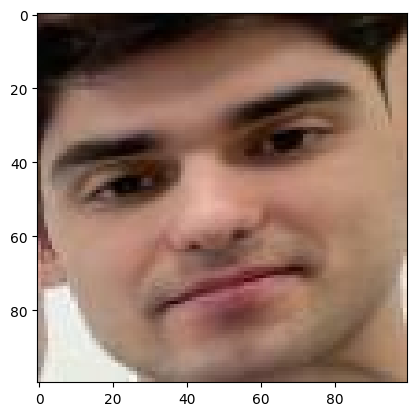

In [38]:
print(next(out))
image = next(im).astype(int)
print(image.shape)
plt.imshow(image)